# Generate Dataset

In [21]:
import os, random
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from math import sqrt
import soundfile as sf
from pystoi import stoi
# from pesq import pesq
from audio_utilities import FeatureExtraction
from python_speech_features import fbank, mfcc
from scipy.io import wavfile

In [2]:
def get_filepaths(dataset_dir, filter_format="wav", get_duration=False):

    filepath_array = []
    speech_duration = 0

    for i, (path, dir_name, file_name) in enumerate(os.walk(dataset_dir)):
        for file in file_name:
            if filter_format in file:
                filepath = path + "/" + file
                filepath_array.append(filepath)

                if get_duration:
                    load_file = sf.SoundFile(filepath)
                    speech_duration += len(load_file) / load_file.samplerate

    print("Got {} .{} Files".format(len(filepath_array), filter_format))
    if get_duration:
        print("Total Duration: {}m".format(int(speech_duration/60)))

    return filepath_array

def add_noise_speech(speech, noise, snr=5):

    rms_speech = sqrt(np.mean(speech ** 2))
    rms_noise_req = sqrt(rms_speech ** 2/pow(10, snr/10))

    rms_noise = sqrt(np.mean(noise ** 2))
    noise_mod = noise * (rms_noise/rms_noise_req)

    return speech + noise_mod

def get_melbands_gain(clean_speech_stft, noisy_speech_stft, melbands=22):

    clean_mel = audio_utils.get_melspectrogram(audio_stft=clean_speech_stft, number_of_melbands=melbands)
    noisy_mel = audio_utils.get_melspectrogram(audio_stft=noisy_speech_stft, number_of_melbands=melbands)

    gains_speech = np.sqrt(np.divide(clean_mel, noisy_mel))
    # gains_speech = np.where(gains_speech <= 0.01, 0.01, gains_speech)
    # gains_speech = np.divide(gains_speech, np.max(gains_speech))

    return gains_speech

def get_features(clean_speech, noisy_speech, melbands=22, delta_melbands=9):

    # Extract MFCC & Relative Derivatives
    noisy_speech_stft = audio_utils.stft(noisy_speech)
    noisy_speech_mfcc = audio_utils.get_mfccs_from_spectrogram(noisy_speech_stft,
                                                               number_of_melbands=melbands)
    noisy_speech_mfcc_delta, \
    noisy_speech_mfcc_delta2 = audio_utils.get_mfccs_delta(noisy_speech_mfcc,
                                                           number_of_melbands=delta_melbands)

    # Extract Spectral Centroid & Bandwidth
    noisy_speech_spec_centroid = audio_utils.get_spectral_centroid(audio_stft=noisy_speech_stft)
    noise_speech_spec_bandwidth = audio_utils.get_spectral_bandwidth(audio_stft=noisy_speech_stft)

    # Extract Gains
    speech_concat_stft = audio_utils.stft(clean_speech)
    speech_melband_gains = get_melbands_gain(clean_speech_stft=speech_concat_stft,
                                             noisy_speech_stft=noisy_speech_stft,
                                             melbands=melbands)

    return  noisy_speech_mfcc, noisy_speech_mfcc_delta, noisy_speech_mfcc_delta2, \
            noisy_speech_spec_centroid, noise_speech_spec_bandwidth, speech_melband_gains


In [31]:

sampling_rate = 16000
frame_length = 1024
hop_length = 512
window_length = 1024
window_function = "vorbis"
number_of_melbands = 22
number_of_features = 42

snr_req = [-5, 0, 5]
# features_speech = []
# features_gain = []
features_speech = np.ndarray((number_of_features,0))
features_gain = np.ndarray((number_of_melbands, 0))

audio_utils = FeatureExtraction(sampling_rate=sampling_rate,
                                frame_length=frame_length, hop_length=hop_length,
                                window_length=window_length, window_function=window_function)

noise_database_path = "Dataset Structure/Dataset/Noise"
speech_database_path = "Dataset Structure/Dataset/Speech"
print("Noise: {}\nSpeech: {}\n".format(noise_database_path, speech_database_path))

noise_file_paths = get_filepaths(dataset_dir=noise_database_path, get_duration=True)
speech_file_paths = get_filepaths(dataset_dir=speech_database_path, get_duration=True)


Noise: Dataset Structure/Dataset/Noise
Speech: Dataset Structure/Dataset/Speech

Got 9 .wav Files
Total Duration: 9m
Got 30819 .wav Files
Total Duration: 1521m


In [ ]:
# for snr in snr_req:
#     print("\n========== SNR {} ============".format(snr))

# for noise_file_path in noise_file_paths:
#
#     # Load Noise
#     noise_file = audio_utils.load_audiofile(noise_file_path)
#     print("\nCurrently Used Noise:", noise_file_path, len(noise_file))
#
#     speech_file_iterator = 0
#     while speech_file_iterator < len(speech_file_paths):
#
#         speech_file = audio_utils.load_audiofile(speech_file_paths[speech_file_iterator])
#         speech_concat = speech_file
#
#         # Concat Speech Till Size of Noise
#         while len(speech_concat) < len(noise_file):
#
#             speech_file_iterator += 1
#
#             # Break when file ends
#             if speech_file_iterator >= len(speech_file_paths):
#                 # print(speech_file_iterator)
#                 break
#             else:
#                 speech_file = audio_utils.load_audiofile(speech_file_paths[speech_file_iterator])
#                 speech_concat = np.concatenate((speech_concat, speech_file))
#                 print("Audio To Be Added: ", speech_file_paths[speech_file_iterator])
#
#                 if len(speech_concat) >= len(noise_file):
#
#                     # Truncate Speech Array to Noise Length
#                     speech_concat = speech_concat[:len(noise_file)]
#
#                     # Add Noise to Speech
#                     random_snr = random.randint(0, len(snr_req)-1)
#                     noisy_speech = add_noise_speech(speech_concat, noise_file, snr=snr_req[random_snr])
#
#                     # Get Features
#                     mfcc, mfcc_d, mfcc_d2, \
#                     spec_centroid, spec_bandwidth, gains = get_features(clean_speech=speech_concat,
#                                                                         noisy_speech=noisy_speech)
#
#                     # print(len(mfcc), len(mfcc_d), len(mfcc_d2),
#                     #       len(spec_centroid), len(spec_bandwidth), len(gains))
#
#                     # Add Features to Array
#                     features = np.concatenate((mfcc, mfcc_d, mfcc_d2,
#                                                spec_bandwidth, spec_centroid), axis=0)
#
#                     features_speech = np.concatenate((features_speech, features), axis=1)
#                     features_gain = np.concatenate((features_gain, gains), axis=1)
#
#                     print("Added Noise to Speech: ", features_speech.shape, features_gain.shape, "\n")
#
#                     break


speech_iterator = 0
noise_iterator = 0

while speech_iterator < len(speech_file_paths):

    # Iterate Through Noise
    noise_iterator += 1

    # Reset Noise Iterator
    if noise_iterator >= len(noise_file_paths):
        noise_iterator = 0

    # Define Concatenated Speech
    speech_concat = np.array([])

    # Load Noise
    noise_file = audio_utils.load_audiofile(noise_file_paths[noise_iterator])
    print("[{}]".format(noise_iterator),"\nCurrently Used Noise:", noise_file_paths[noise_iterator], len(noise_file), "\n")

    while len(speech_concat) < len(noise_file):
        # Load Speech
        speech_file = audio_utils.load_audiofile(speech_file_paths[speech_iterator])
        print("Currently Used Speech:", speech_file_paths[speech_iterator], len(speech_file))

        # Concat Speech
        speech_concat = np.concatenate((speech_concat, speech_file))
        speech_iterator += 1

        if speech_iterator >= len(speech_file_paths):
            break

    # Truncate Speech Array to Noise Length
    if len(speech_concat) >= len(noise_file):
        speech_concat = speech_concat[:len(noise_file)]
    else:
        noise_file = noise_file[:len(speech_concat)]

    # Add Noise to Speech
    random_snr = random.randint(0, len(snr_req)-1)
    noisy_speech = add_noise_speech(speech_concat, noise_file, snr=snr_req[random_snr])

    # Get Features
    mfcc, mfcc_d, mfcc_d2, \
    spec_centroid, spec_bandwidth, gains = get_features(clean_speech=speech_concat,
                                                        noisy_speech=noisy_speech)

    # print(len(mfcc), len(mfcc_d), len(mfcc_d2),
    #       len(spec_centroid), len(spec_bandwidth), len(gains))

    # Add Features to Array
    features = np.concatenate((mfcc, mfcc_d, mfcc_d2,
                               spec_bandwidth, spec_centroid), axis=0)

    features_speech = np.concatenate((features_speech, features), axis=1)
    features_gain = np.concatenate((features_gain, gains), axis=1)

    print("[{}]".format(speech_iterator),"\nAdded Noise to Speech: ",
          features_speech.shape, features_gain.shape, "\n")


### Save to File

In [ ]:
print("Saving To File")
np.savez_compressed("feature_dataset.npz", speech_features=features_speech, gains=features_gain)

### Loading From File

In [ ]:
from sklearn.model_selection import train_test_split
print("Loading From File")

filename = "feature_dataset.npz"

with np.load(filename) as data:
    speech_features = data["speech_features"]
    gains = data["gains"]
    # print(np.max(gains))

    # for i in range(0, 2):
    #     speech_features = np.concatenate((speech_features, speech_features), axis=1)
    #     gains = np.concatenate((gains, gains), axis=1)
    #     print("Concat Iteration {}".format(i))

    gains = np.clip(gains, 0, 1)
    # print(np.max(gains))

    # Reshape (if Reqd)
    speech_features = speech_features.transpose()
    gains = gains.transpose()

    print(speech_features.shape, gains.shape)

    # x_train, x_test, y_train, y_test = train_test_split(speech_features, gains,
    #                                                     test_size=0.3)

    # x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train,
    #                                                                 test_size=0.2)

    window_size = 2000
    number_of_sequences = int(len(speech_features)/window_size)

    x = speech_features[:number_of_sequences*window_size]
    y = gains[:number_of_sequences*window_size]

    print(x.shape, y.shape)

    x_train = np.reshape(x, (number_of_sequences, window_size, x.shape[1]))
    y_train = np.reshape(y, (number_of_sequences, window_size, y.shape[1]))

    print(x_train.shape, y_train.shape)

# Equalizer

/home/abish/Documents/Project/Speech-Enhancement-Model/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/abish/Documents/Project/Speech-Enhancement-Model/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


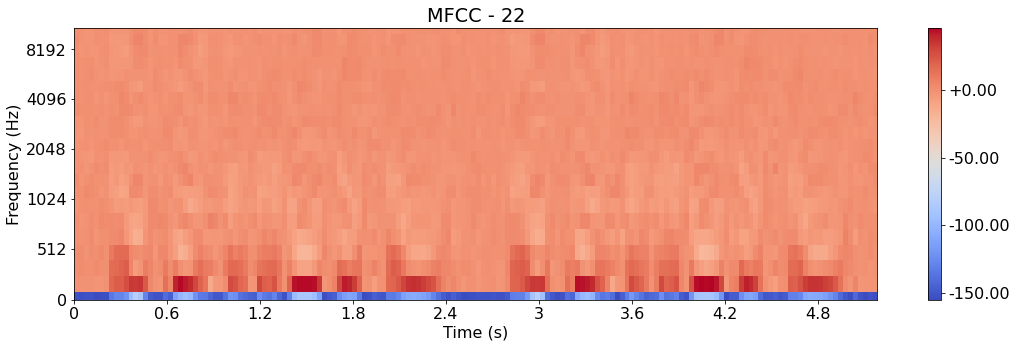

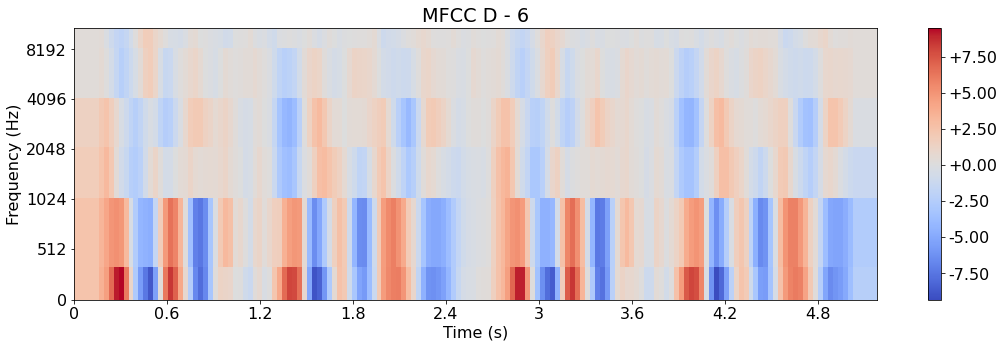

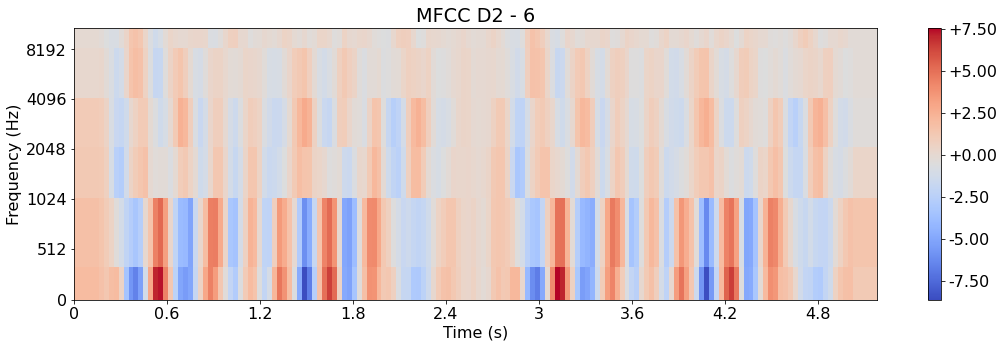

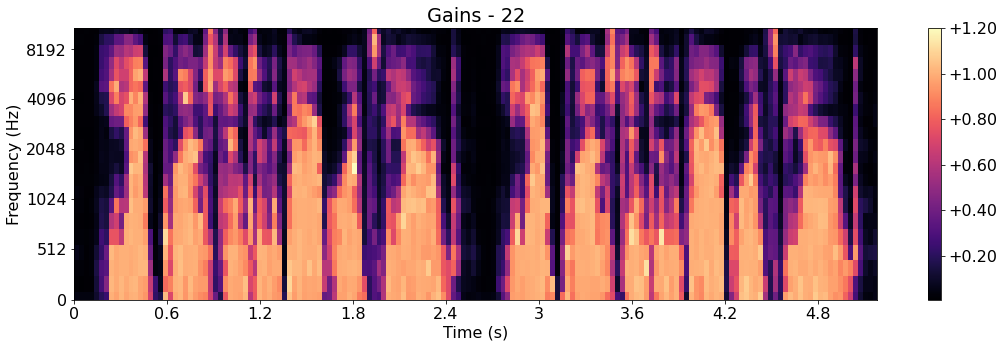

In [4]:
# Create Noisy Speech

speech_file = "Audio Samples/Female_Speech.WAV"
noise_file = "Dataset Structure/Dataset/Noise/white.wav"

speech = audio_utils.load_audiofile(speech_file)
speech = np.concatenate((speech, speech))
noise = audio_utils.load_audiofile(noise_file)[:len(speech)]

noisy_speech = add_noise_speech(speech, noise, snr=0)

# Generate Features
mfcc, mfcc_d, mfcc_d2, \
spec_centroid, spec_bandwidth, gains = get_features(clean_speech=speech,
                                                    noisy_speech=noisy_speech,
                                                    melbands=22, delta_melbands=6)

def plot_feature(feature, sr=16000, title=""):
    plt.figure(figsize=(18, 5))
    librosa.display.specshow(data=feature, sr=sr,
                             x_axis="time", y_axis="mel")
    plt.colorbar(format="%+.2f")
    plt.title((title+" - {}").format(len(feature)))
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.show()

plot_feature(mfcc, title="MFCC")
plot_feature(mfcc_d, title="MFCC D")
plot_feature(mfcc_d2, title="MFCC D2")
plot_feature(gains, title="Gains")

# Clipped Gains
# print(np.max(gains))
# gains = np.clip(gains, 0, 1)

# plot_feature(gains, title="Gains")

gains = gains.transpose()

### Python Speech Features

16.967234898857964 -36.96999043745059
0.7371636319122719 -1.0


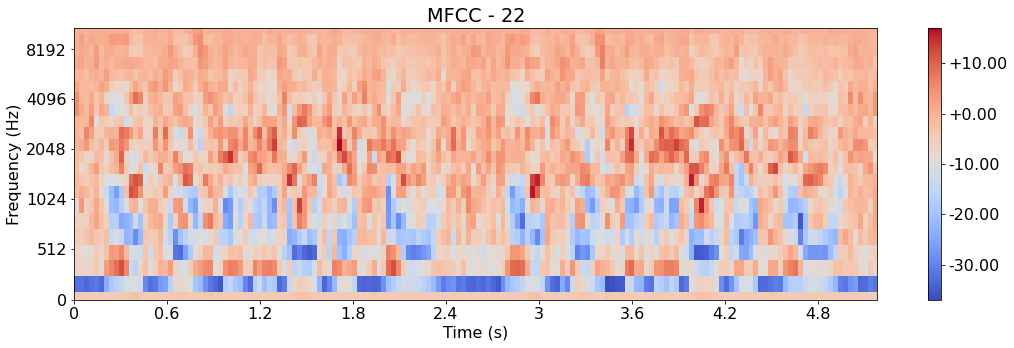

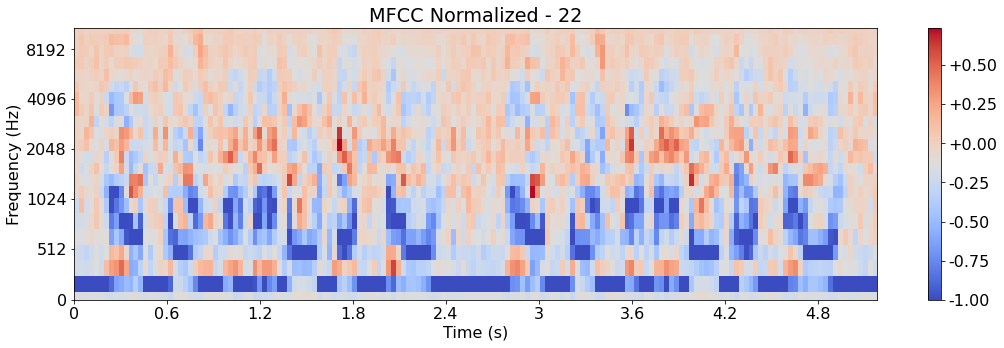

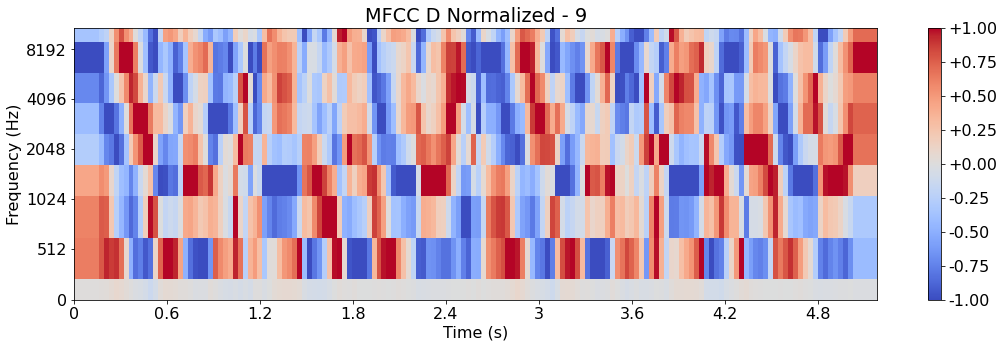

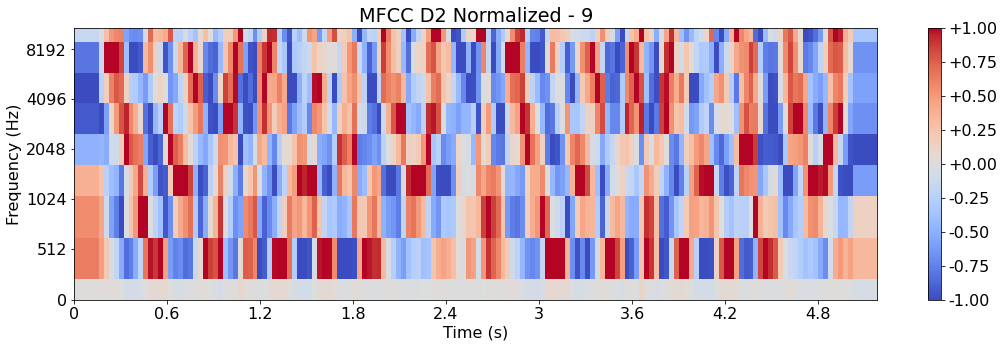

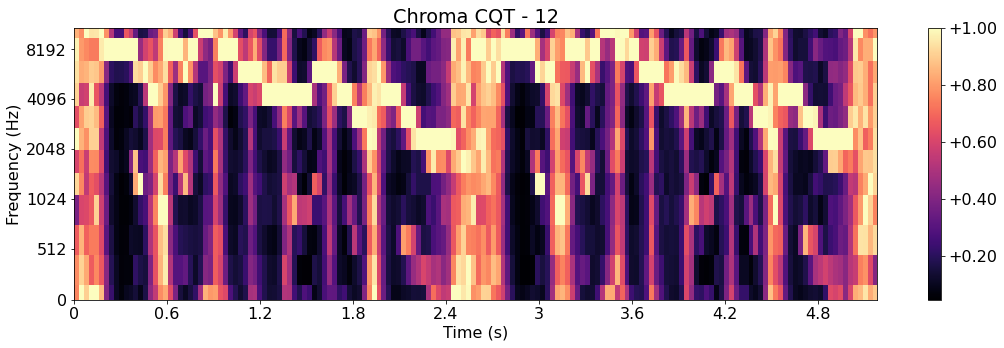

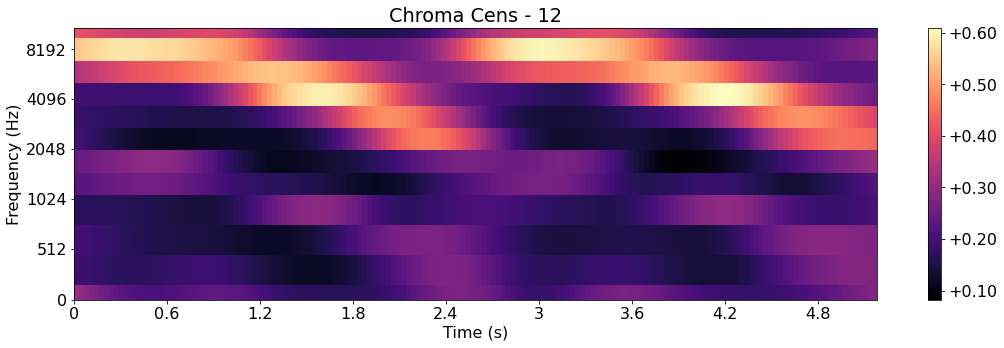

In [10]:
import python_speech_features
# gains_psf, _ = python_speech_features.fbank(noisy_speech,
#                                           samplerate=16000, nfilt=22,
#                                           winlen=0.032,winstep=0.032, nfft=1024)
# gains_psf = gains_psf.T
# plot_feature(gains_psf, title="Gains")

mfcc_psf = python_speech_features.mfcc(signal=noisy_speech, samplerate=16000, numcep=22,
                                       nfilt=22, winlen=0.032, winstep=0.032, nfft=1024)
mfcc_psf = mfcc_psf.T

print(np.max(mfcc_psf), np.min(mfcc_psf))

mfcc_psf_d = librosa.feature.delta(mfcc_psf)[:9]
mfcc_psf_d = librosa.util.normalize(mfcc_psf_d)

mfcc_psf_d2 = librosa.feature.delta(mfcc_psf, order=2)[:9]
mfcc_psf_d2 = librosa.util.normalize(mfcc_psf_d2)

mfcc_psf_n = librosa.util.normalize(mfcc_psf)
print(np.max(mfcc_psf_n), np.min(mfcc_psf_n))

chroma_cq = librosa.feature.chroma_cqt(y=noisy_speech, sr=16000, hop_length=512)
chroma_cens = librosa.feature.chroma_cens(y=noisy_speech, sr=16000, hop_length=512)

plot_feature(mfcc_psf, title="MFCC")
plot_feature(mfcc_psf_n, title="MFCC Normalized")
plot_feature(mfcc_psf_d, title="MFCC D Normalized")
plot_feature(mfcc_psf_d2, title="MFCC D2 Normalized")
plot_feature(chroma_cq, title="Chroma CQT")
plot_feature(chroma_cens, title="Chroma Cens")

### IIR Filter

FreqBands:  [   0.          143.63695388  287.27390776  430.91086164  574.54781552
  718.1847694   861.82172327 1005.64528123 1166.2096151  1352.41013083
 1568.3399779  1818.74583027 2109.1322301  2445.88259118 2836.39952226
 3289.26755474 3814.44185199 4423.46704853 5129.73102978 5948.75923099
 6898.55592482 8000.        ]
[ 143.63695388  287.27390776  430.91086164  574.54781552  718.1847694
  861.82172327 1005.64528123 1166.2096151  1352.41013083 1568.3399779
 1818.74583027 2109.1322301  2445.88259118 2836.39952226 3289.26755474
 3814.44185199 4423.46704853 5129.73102978 5948.75923099 6898.55592482]

 18 18


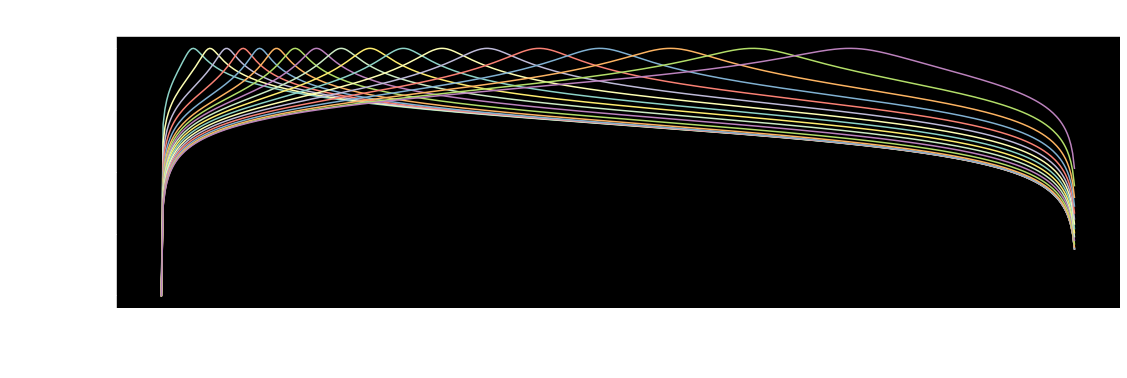

512


In [11]:
freqbands = librosa.filters.mel_frequencies(n_mels=22, fmax=sampling_rate/2)
print("FreqBands: ", freqbands)

# Avoid first and last freq
band_freq = freqbands[1:-1]
print(band_freq)

# from scipy import signal

# Get BandFilter Coefficient
# def get_band_filter_coefficient(f0, sr=16000, Q=1.0):
#     # w0 = 2*pi*f/sr
#     w0 = (2 * np.pi * f0) / sr
#     alpha = np.sin(w0) / (2 * Q)
#     a = np.zeros(3)
#     b = np.zeros(3)
#     b[0] = Q * alpha
#     b[1] = 0
#     b[2] = -Q * alpha
#     a[0] = 1 + alpha
#     a[1] = -2 * np.cos(w0)
#     a[2] = 1 - alpha
#     return b, a

def iir_filter_design(band_frequency, sampling_frequency=16000, order=1):
    b, a = [], []

    f = band_frequency / (sampling_frequency/2)

    for i in range(1, len(band_frequency)-1):
        b_, a_ = signal.iirfilter(order,
                                  [f[i] - (f[i]-f[i-1])/2, f[i]+ (f[i+1]-f[i])/2],
                                  btype="bandpass", output="ba")

        a.append(a_)
        b.append(b_)

    print("\n", len(b), len(a))
    # print("\nb: ", b)
    # print("a: ", a)
    return  b, a

def bandpass_filter(noisy_speech, b, a, hop_length, gains):

    # Define Filtered Output
    y = np.zeros(len(noisy_speech))

    state = np.zeros(len(b) - 1)
    # Initial Gain
    g = 0

    for n in range(0, len(gains)):
        g = max(0.6 * g, gains[n])
        b_ = b * g
        a_ = a
        filtered, state = signal.lfilter(b_, a_, noisy_speech[n*hop_length: min((n+1)*hop_length, len(noisy_speech))], zi=state)
        y[n*hop_length: min((n+1)*hop_length, len(noisy_speech))] = filtered
        # filtered, state = signal.lfilter(b_, a_, x_signal, zi=state)
        # y = filtered
    return y

def plot_frequency_response(b, a=None, sampling_frequency=16000):

    if len(a) != len(b):
        a = np.ones(len(b))

    plt.figure(figsize=(18, 5))
    plt.rcParams.update({'font.size': 26})
    plt.style.use(['dark_background'])

    for i in range(len(b)):
        w, h = signal.freqz(b[i], a[i])
        plt.plot(w * 0.15915494327 * sampling_frequency,
                 20 * np.log10(np.maximum(abs(h), 1e-5)))

    plt.title('Frequency Response')
    plt.ylabel('Amplitude (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.show()

b, a = iir_filter_design(band_freq, sampling_frequency=sampling_rate, order=1)
plot_frequency_response(b, a)

hop_length = int(0.032 * sampling_rate)
print(hop_length)

filtered_signal = np.zeros(len(noisy_speech))


# Iterating Through Each Bands
for i in range(len(b)):

    # Filter Each Bands & Add
    filtered_signal += bandpass_filter(noisy_speech, b[i].copy(), a[i].copy(),
                                       hop_length=512, gains=gains[:, i])
    # print(gains[:, i])


In [ ]:
ipd.Audio(filtered_signal, rate=16000)

In [ ]:
ipd.Audio(noisy_speech, rate=16000)

### Evaluation

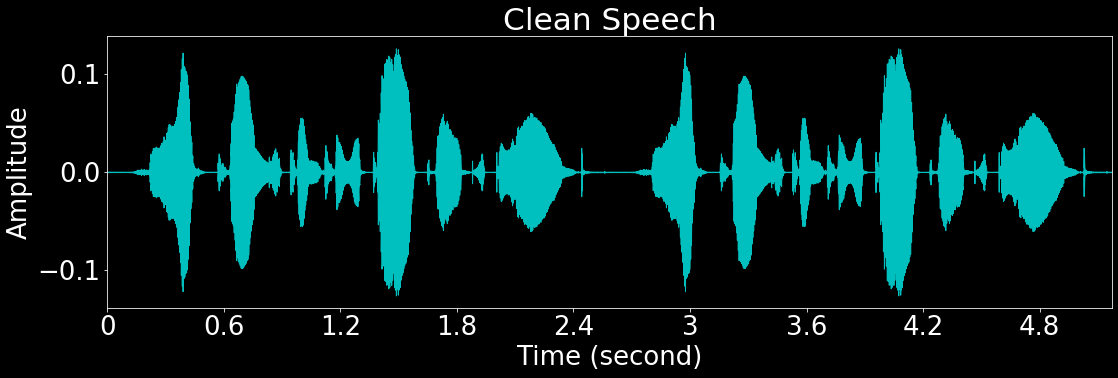

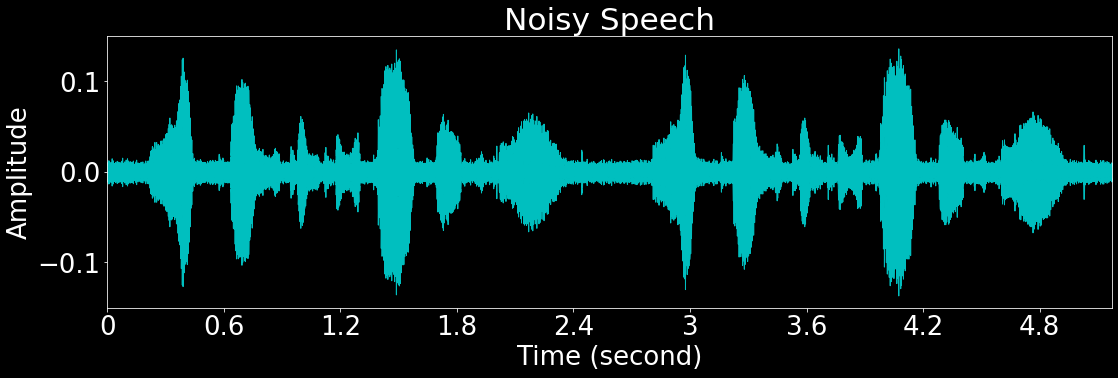

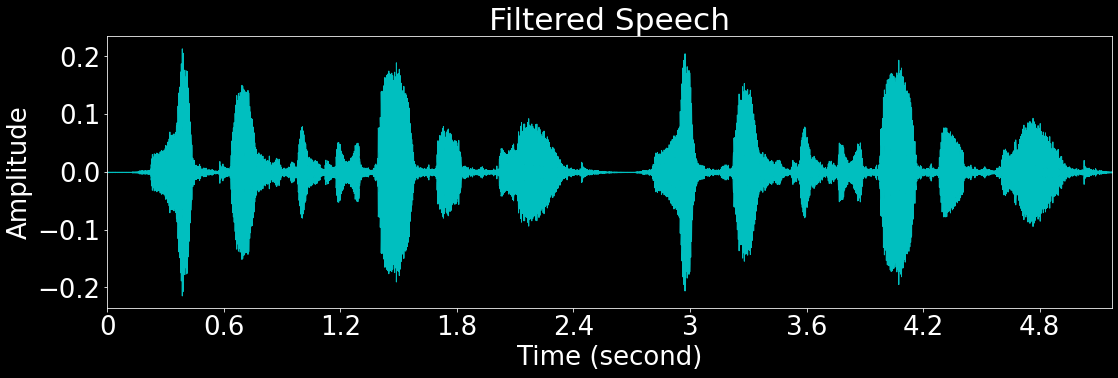

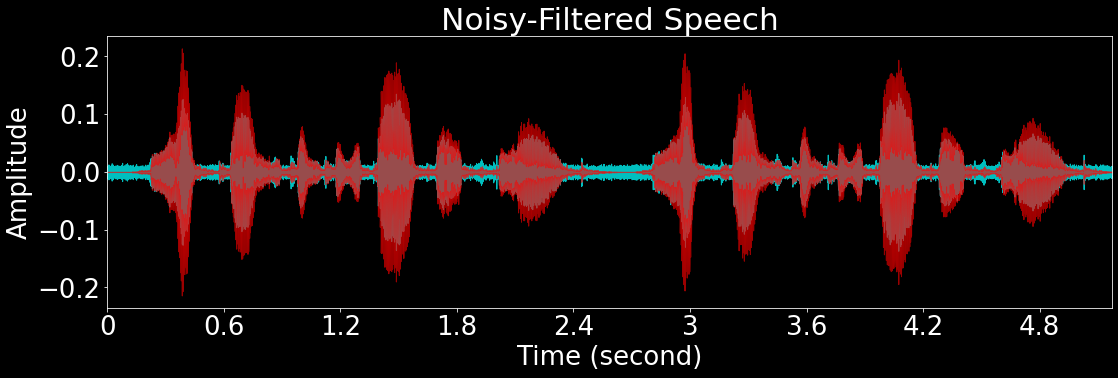

In [12]:
# noisy_stoi = stoi(speech, noisy_speech, 16000, extended=False)
# noisy_pesq = pesq(fs=16000, ref=speech, deg=noisy_speech, mode='wb')
# filtered_stoi = stoi(speech, filtered_signal, 16000, extended=False)
# filtered_pesq = pesq(fs=16000, ref=speech, deg=filtered_signal, mode='wb')
#
# print("STOI : {} PESQ : {}".format(round(noisy_stoi, 4), round(noisy_pesq, 4)))
# print("STOI : {} PESQ : {}".format(round(filtered_stoi, 4), round(filtered_pesq, 4)))

def plot_wave(audio, sr=16000, evaluate_audio = None, title=None):
    plt.rcParams.update({'font.size': 26})
    plt.style.use(['dark_background'])
    plt.figure(figsize=(18, 5))
    librosa.display.waveplot(audio, sr=sr, color='c', alpha=1)
    if evaluate_audio is not None:
        librosa.display.waveplot(evaluate_audio, sr, color='r', alpha=0.6)
    if title is None:
        plt.title("Wave Plot")
    else:
        plt.title(title)
    plt.xlabel("Time (second)")
    plt.ylabel("Amplitude")
    plt.show()

plot_wave(speech, sr=sampling_rate, title="Clean Speech")
plot_wave(noisy_speech, sr=sampling_rate, title="Noisy Speech")
plot_wave(filtered_signal, sr=sampling_rate, title="Filtered Speech")
plot_wave(noisy_speech, sr=sampling_rate, title="Noisy-Filtered Speech",
          evaluate_audio=filtered_signal)

In [42]:
# def generate_dataset_ms(path, vad_active_delay=0.07, vad_threshold=1e-1, random_volume=True,
#                         winlen=0.032, winstep=0.032/2,
#                         numcep=13, nfilt=26, nfft=512,
#                         lowfreq=20, highfreq=8000, winfunc=np.hanning,
#                         ceplifter=0, preemph=0.97, appendEnergy=True):
#
#     print("Using Microsoft Scalable Database")
#
#     mfccs, band_energy, total_energy, filenames = [], [], [], []
#
#     speech_file_paths = get_filepaths(dataset_dir=path, get_duration=True)
#
#     for file in speech_file_paths:
#         (_rate, _signal) = wav.read(path + '/' + file)
#         _signal = _signal/32768
#
#         mfcc_feat = mfcc(sig, rate, winlen=winlen, winstep=winstep, numcep=numcep, nfilt=nfilt, nfft=nfft,
#                          lowfreq=lowfreq, highfreq=highfreq, winfunc=winfunc, ceplifter=ceplifter, preemph=preemph,
#                          appendEnergy=appendEnergy)
#
#         band_eng, total_eng = fbank(sig, rate, winlen=winlen, winstep=winstep, nfilt=nfilt, nfft=nfft, lowfreq=lowfreq,
#                                     highfreq=highfreq, preemph=preemph, winfunc=winfunc)
#
#         total_energy.append(total_eng)
#         band_energy.append(band_eng)
#         mfccs.append(mfcc_feat.astype('float32'))
#         filenames.append(file)
#
#     return mfccs, band_energy, filenames

clean_speech_files = get_filepaths(
    dataset_dir="Dataset Structure/Dataset/MS/CleanSpeech_training",
    get_duration=True
)
noise_speech_files = get_filepaths(
    dataset_dir="Dataset Structure/Dataset/MS/NoisySpeech_training",
    get_duration=True
)

mfccs = np.ndarray((0, 22))
gains = np.ndarray((0, 22))
spec_centroid = np.ndarray((0, 1))
spec_bandwidth = np.ndarray((0, 1))
total_energy = np.array([])

clean_speech_iterator = 0

for clean_speech_file in clean_speech_files:

    # Get filename without extension .wav
    filename = clean_speech_file.split("/")[-1]

    print("[{}] Clean Speech File: {}".format(clean_speech_iterator, filename))
    clean_speech_iterator += 1

    # Find corresponding files from noisy speech
    _temp_noisy_files = []
    for noisy_speech_file in noise_speech_files:
        if filename in noisy_speech_file:
            _temp_noisy_files.append(noisy_speech_file)

    # Check Whether Array Has 4 SNR Files
    if len(_temp_noisy_files) != 4:
        print("Couldn't get 4 SNR Files")
        break

    (rate, _speech) = wavfile.read(clean_speech_file)
    _speech = _speech / 32768

    _band_energy_speech, _total_energy_speech = fbank(
            signal=_speech, samplerate=16000, winlen=0.032, winstep=0.016,
            nfft=1024, nfilt=22, lowfreq=20, highfreq=8000
        )

    noisy_speech_iterator = 0
    for file in _temp_noisy_files:
        # Load Noisy Signal
        (rate, _noise) = wavfile.read(file)
        _noise = _noise / 32768

        # Compute MFCC

        _mfcc = mfcc(
            signal=_noise, samplerate=16000, winlen=0.032, winstep=0.016,
            nfft=1024, nfilt=22, numcep=22, lowfreq=20, highfreq=8000
        )

        # Compute Gain
        _band_energy_noise, _total_energy_noise = fbank(
            signal=_noise, samplerate=16000, winlen=0.032, winstep=0.016,
            nfft=1024, nfilt=22, lowfreq=20, highfreq=8000
        )

        _gains = np.sqrt(np.divide(_band_energy_speech, _band_energy_noise))
        # _gains = np.clip(_gains, 0, 1)

        #  # Extract Spectral Centroid & Bandwidth
        # _stft = audio_utils.stft(_noise)
        # _spec_centroid = audio_utils.get_spectral_centroid(audio_stft=_stft)
        # _spec_bandwidth = audio_utils.get_spectral_bandwidth(audio_stft=_stft)

        # Append MFCC and Gains
        mfccs = np.concatenate((mfccs, _mfcc))
        gains = np.concatenate((gains, _gains))
        total_energy = np.concatenate((total_energy, _total_energy_noise))
        # spec_centroid = np.concatenate((spec_centroid, _spec_centroid.T))
        # spec_bandwidth = np.concatenate((spec_bandwidth, _spec_bandwidth.T))


        print("[{}] Used Noisy Signal: {}".format(noisy_speech_iterator, file.split("/")[-1]))
        noisy_speech_iterator += 1

    print(mfccs.shape, gains.shape, total_energy.shape)


Got 219 .wav Files
Total Duration: 225m
Got 876 .wav Files
Total Duration: 901m
[0] Clean Speech File: clnsp104.wav
[0] Used Noisy Signal: noisy104_SNRdb_10.0_clnsp104.wav
[1] Used Noisy Signal: noisy104_SNRdb_-5.0_clnsp104.wav
[2] Used Noisy Signal: noisy104_SNRdb_5.0_clnsp104.wav
[3] Used Noisy Signal: noisy104_SNRdb_0.0_clnsp104.wav
(15456, 22) (15456, 22) (15456,) (0, 1) (0, 1)
[1] Clean Speech File: clnsp10.wav
[0] Used Noisy Signal: noisy10_SNRdb_5.0_clnsp10.wav
[1] Used Noisy Signal: noisy10_SNRdb_10.0_clnsp10.wav
[2] Used Noisy Signal: noisy10_SNRdb_-5.0_clnsp10.wav
[3] Used Noisy Signal: noisy10_SNRdb_0.0_clnsp10.wav
(30704, 22) (30704, 22) (30704,) (0, 1) (0, 1)
[2] Clean Speech File: clnsp199.wav
[0] Used Noisy Signal: noisy199_SNRdb_10.0_clnsp199.wav
[1] Used Noisy Signal: noisy199_SNRdb_-5.0_clnsp199.wav
[2] Used Noisy Signal: noisy199_SNRdb_0.0_clnsp199.wav
[3] Used Noisy Signal: noisy199_SNRdb_5.0_clnsp199.wav
(45860, 22) (45860, 22) (45860,) (0, 1) (0, 1)
[3] Clean Spee

In [43]:
def normalize(data, n, quantize=True):
    limit = pow(2, n)
    data = np.clip(data, -limit, limit)/limit
    if quantize:
        data = np.round(data * 128)/ 128.0
    return data

mfccs = normalize(data=mfccs, n=3, quantize=False)

gains = gains.T
mfccs = mfccs.T
mfcc_d, mfcc_d2 = audio_utils.get_mfccs_delta(mfccs, number_of_melbands=9)
mfccs = np.concatenate((mfccs, mfcc_d, mfcc_d2))

In [ ]:
print(spec_centroid.shape, spec_bandwidth.shape)
spectral_features = np.concatenate((spec_centroid, spec_bandwidth))


In [45]:
np.savez_compressed("../Generated Features/feature_dataset_ms_psf.npz",
                    speech_features=mfccs,
                    # spectral_features=spectral_features,
                    gains=gains)
